In [1]:
import os
import datetime as dt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from metpy.plots import USCOUNTIES

from harmony import BBox, Client, Collection, Request, Environment, CapabilitiesRequest
from IPython.display import JSON

# Examine request capabilities for TEMPO collections

In [2]:
harmony_client = Client(env=Environment.UAT)

capabilities_request = CapabilitiesRequest(collection_id='C1254854453-LARC_CLOUD')
capabilities = harmony_client.submit(capabilities_request)

JSON(capabilities, expanded=True)

<IPython.core.display.JSON object>

# How to form and submit a request to L2SS-B-S-C chain

In [3]:
collection = Collection(id='C1254854453-LARC_CLOUD')


request_examples = [
  ### example 1: all possible request parameters
  Request(
    collection=collection,
    spatial=BBox(-130, 30, -90, 40),
    temporal={
        'start': dt.datetime(2023, 1, 1),
        'stop': dt.datetime(2024, 12, 30)
    },
    variables=["/product/vertical_column_total"],
    extend="mirror_step"
  ),
  ### example 2: minimal request parameters
  Request(
    collection=collection,
    extend="mirror_step",
  ),
  ### example 3: spatial subsetting required
  Request(
    collection=collection,
    spatial=BBox(-130, 30, -90, 40),
    extend="mirror_step"
  ),
  ### example 4: temporal subsetting required
  Request(
    collection=collection,
    temporal={
        'start': dt.datetime(2023, 1, 1),
        'stop': dt.datetime(2024, 12, 30)
    },
    extend="mirror_step"
  ),
  ### example 5: spatial and temporal subsetting required
  Request(
    collection=collection,
    spatial=BBox(-130, 30, -90, 40),
    temporal={
        'start': dt.datetime(2023, 1, 1),
        'stop': dt.datetime(2024, 12, 30)
    },
    extend="mirror_step"
  ),
  ### example 6: one variable is requested
  Request(
    collection=collection,
    spatial=BBox(-130, 30, -90, 40),
    temporal={
        'start': dt.datetime(2023, 1, 1),
        'stop': dt.datetime(2024, 12, 30)
    },
    variables=["/product/vertical_column_total"],
    extend="mirror_step"
  )
]

assert all([req.is_valid() for req in request_examples])

request = request_examples[0]
jid = harmony_client.submit(request)
harmony_client.wait_for_processing(jid, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


# See the detailed status of the job and the REST API request

In [4]:
data=harmony_client.status(jid)
JSON(data)

<IPython.core.display.JSON object>

# Download all output data files

In [5]:
output_files=[]
for url in harmony_client.result_urls(jid):
  step_id,filename = url.split("/")[-2:]
  try:
    os.mkdir(f"uat/{jid}")
    os.mkdir(f"uat/{jid}/{step_id}")
  except:
    pass
  fut = harmony_client.download(url, directory=f"uat/{jid}/{step_id}")
  output_files.append(fut.result())

uat/302910c7-d621-403b-9ef8-4c938fa0136c/4021081/C1254854453-LARC_CLOUD_merged.nc4


# Define plotting functions

In [6]:
def get_XYC(filepath, product_name, index=-1):
  ds_root = xr.open_dataset(filepath)
  ds_product = xr.open_dataset(filepath, group="product")
  ds_geo = xr.open_dataset(filepath, group="geolocation")

  if index<0:
    X, Y, C = ds_geo.longitude.values, ds_geo.latitude.values, ds_product[product_name].values
    filename = filepath
  else:
    X, Y, C = ds_geo.longitude[index].values, ds_geo.latitude[index].values, ds_product[product_name][index].values
    filename = ds_root.subset_files.data[index]
  inds = np.logical_not(np.isnan(X) | np.isnan(Y) | np.isnan(C))

  return filename, X[inds], Y[inds], C[inds]



def plot_map(ax, h2d):
  proj = ccrs.PlateCarree()

  #cmap='terrain_r')
  cmp = plt.cm.terrain_r
  cmp = plt.cm.RdBu_r
  cmp = plt.cm.nipy_spectral_r

  ax.set_extent([-140, -15, 15, 65], crs=proj)

  ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.1, edgecolor='dimgray')
  ax.add_feature(cfeature.OCEAN, linewidth=0.1, edgecolor='dimgray', facecolor='lightsteelblue')
  ax.add_feature(cfeature.LAKES, linewidth=0.1, edgecolor='dimgray', facecolor='lightsteelblue')
  ax.add_feature(cfeature.BORDERS, linewidth=0.1, edgecolor='dimgray')
  ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.1, edgecolor='dimgray')
  ###ax.add_feature(USCOUNTIES.with_scale('20m'), linewidth=0.1)

  (H,xbins,ybins) = h2d
  H=H.T
  ax.pcolormesh(xbins, ybins, H, norm="log", cmap=cmp, alpha=0.8)
  return ax

# Plot heatmap

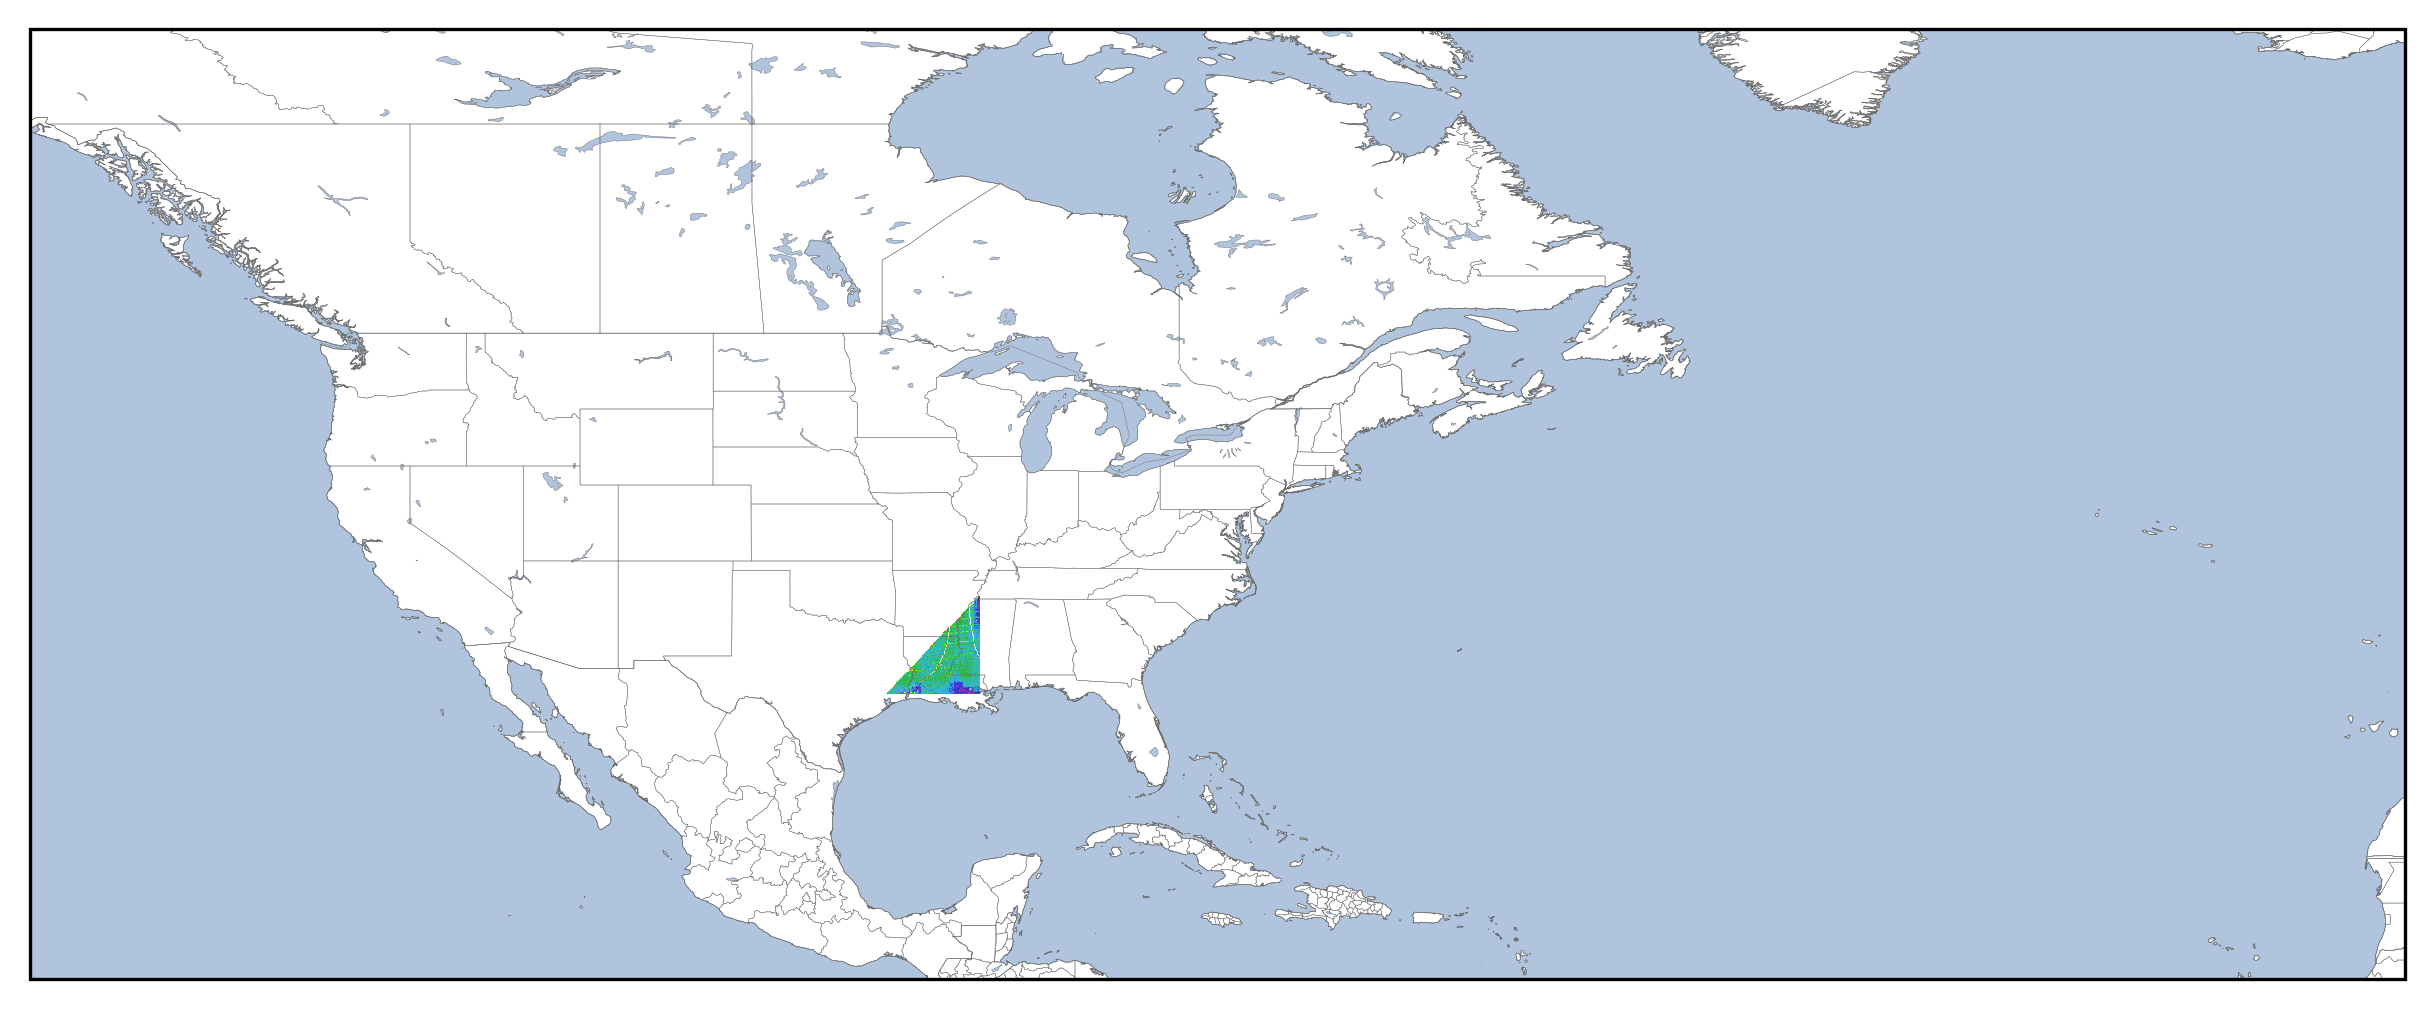

In [7]:
proj = ccrs.PlateCarree()
XYCs = [get_XYC(fn, "vertical_column_total") for fn in output_files]

fig, axs = plt.subplots(figsize=(8, 6.5), dpi=300, facecolor="w", subplot_kw=dict(projection=proj), linewidth=8, edgecolor="white", layout="compressed")
h2d = np.histogram2d(np.concatenate([xx for ff,xx,yy,cc in XYCs]), np.concatenate([yy for ff,xx,yy,cc in XYCs]), weights=np.concatenate([cc for ff,xx,yy,cc in XYCs]), bins=100)

ax = plot_map(axs, h2d)